In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [2]:
# Checking the directories
!ls /content/drive/MyDrive/Laboratorio\ institucional/DATASET/dataset_24_05_2021

test  train


In [3]:
# Set up the dataset image folder 
img_folder = '/content/drive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/train'
test_folder = '/content/drive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/test'

In [4]:
# Set up the trained models folder 
models_folder = '/content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models'

In [6]:
image_size = (160, 160)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_folder,
    validation_split=0.15,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_folder,
    validation_split=0.15,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1100 files belonging to 2 classes.
Using 935 files for training.
Found 1100 files belonging to 2 classes.
Using 165 files for validation.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


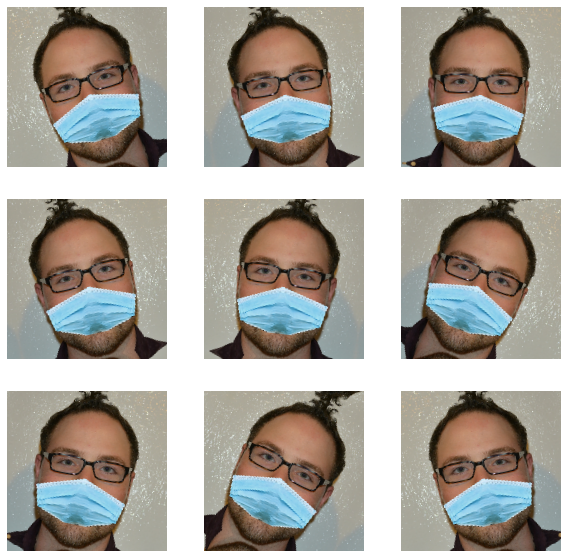

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [13]:
import os

epochs = 50
lr = 1e-3

model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(models_folder,'test_{}_{}_{}_tmp.model'.format(batch_size, lr, epochs)), monitor='val_loss',mode = 'min', save_best_only=True, verbose=1, period=1)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min',patience=10, verbose=1)

callbacks = [
    model_checkpoint, 
    earlyStopping,
]
model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
117/117 [==============================] - 11s 76ms/step - loss: 0.1565 - accuracy: 0.9401 - val_loss: 0.1099 - val_accuracy: 0.9636

Epoch 00001: val_loss improved from inf to 0.10985, saving model to /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model/assets
Epoch 2/50
117/117 [==============================] - 9s 74ms/step - loss: 0.0958 - accuracy: 0.9701 - val_loss: 0.1461 - val_accuracy: 0.9455

Epoch 00002: val_loss did not improve from 0.10985
Epoch 3/50
117/117 [==============================] - 9s 75ms/step - loss: 0.1242 - accuracy: 0.9572 - val_loss: 0.2564 - val_accuracy: 0.9030

Epoch 00003: val_loss did not improve from 0.10985
Epoch 4/50
117/117 [==============================] - 9s 74ms/step - loss: 0.1257 - accuracy: 0.9594 - val_loss: 0.1046 - val_accuracy: 0.9636

Epoch 00004: val_loss improved from 0.10985 to 0.10455, saving model to /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model/assets
Epoch 5/50
117/117 [==============================] - 9s 74ms/step - loss: 0.1143 - accuracy: 0.9583 - val_loss: 0.1427 - val_accuracy: 0.9515

Epoch 00005: val_loss did not improve from 0.10455
Epoch 6/50
117/117 [==============================] - 9s 74ms/step - loss: 0.0607 - accuracy: 0.9754 - val_loss: 0.1004 - val_accuracy: 0.9697

Epoch 00006: val_loss improved from 0.10455 to 0.10041, saving model to /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model/assets
Epoch 7/50
117/117 [==============================] - 9s 75ms/step - loss: 0.1145 - accuracy: 0.9583 - val_loss: 0.2343 - val_accuracy: 0.9455

Epoch 00007: val_loss did not improve from 0.10041
Epoch 8/50
117/117 [==============================] - 9s 74ms/step - loss: 0.1130 - accuracy: 0.9711 - val_loss: 0.1028 - val_accuracy: 0.9697

Epoch 00008: val_loss did not improve from 0.10041
Epoch 9/50
117/117 [==============================] - 9s 76ms/step - loss: 0.1244 - accuracy: 0.9572 - val_loss: 0.1269 - val_accuracy: 0.9394

Epoch 00009: val_loss did not improve from 0.10041
Epoch 10/50
117/117 [==============================] - 9s 74ms/step - loss: 0.0926 - accuracy: 0.9668 - val_loss: 1.1242 - val_accuracy: 0.6485

Epoch 00010: val_loss did not improve from 0.10041
Epoch 11/50
117/117 [==============================] - 9s 74ms/step - loss: 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Laboratorio institucional/proyecto_cnn/new_models/test_8_0.001_50_tmp.model/assets
Epoch 14/50
117/117 [==============================] - 9s 75ms/step - loss: 0.1110 - accuracy: 0.9679 - val_loss: 0.5514 - val_accuracy: 0.7455

Epoch 00014: val_loss did not improve from 0.07832
Epoch 15/50
117/117 [==============================] - 9s 74ms/step - loss: 0.0741 - accuracy: 0.9701 - val_loss: 0.1087 - val_accuracy: 0.9576

Epoch 00015: val_loss did not improve from 0.07832
Epoch 16/50
117/117 [==============================] - 9s 75ms/step - loss: 0.0879 - accuracy: 0.9711 - val_loss: 0.1610 - val_accuracy: 0.9394

Epoch 00016: val_loss did not improve from 0.07832
Epoch 17/50
117/117 [==============================] - 9s 75ms/step - loss: 0.1051 - accuracy: 0.9679 - val_loss: 0.1543 - val_accuracy: 0.9636

Epoch 00017: val_loss did not improve from 0.07832
Epoch 18/50
117/117 [==============================] - 9s 75ms/step - loss

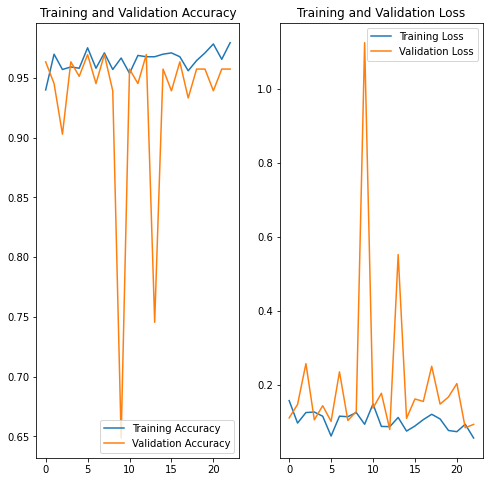

In [15]:
# Showing the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  image_size=(160, 160),
  batch_size=batch_size)

Found 150 files belonging to 2 classes.


In [52]:
(loss_test, acc_test) = model.evaluate(test_ds)
(loss_test, acc_test)

19/19 [==============================] - 1s 41ms/step - loss: 0.2793 - accuracy: 0.8600


(0.27932795882225037, 0.8600000143051147)

In [61]:
for image_batch, labels_batch in test_ds.take(2):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 160, 160, 3)
(8,)


In [62]:
predictions = np.rint(model.predict(image_batch))

In [59]:
import numpy as np

In [63]:
predictions, labels_batch.numpy()

(array([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]], dtype=float32), array([0, 1, 1, 1, 1, 1, 1, 0], dtype=int32))

In [25]:
class_names = test_ds.class_names
print(class_names)

['con_mascarilla1', 'sin_mascarillatotal']


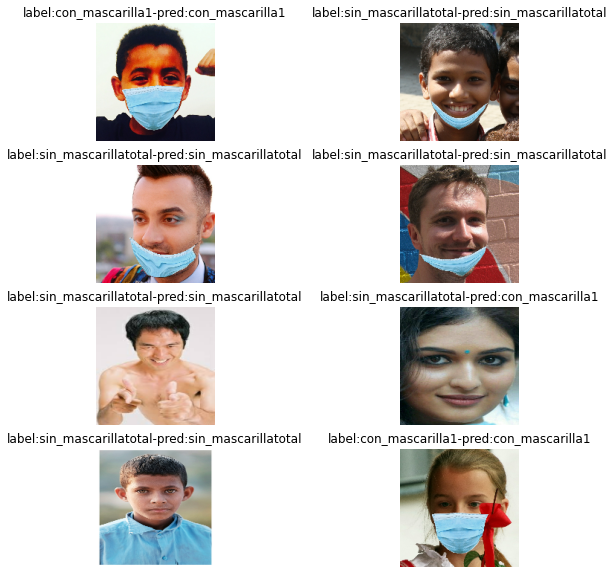

In [64]:
plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='seismic')
    plt.title('label:'+class_names[labels_batch.numpy()[i]]+'-pred:'+class_names[predictions.astype('int')[i][0]])
    plt.axis("off")